## Importing Modules

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, auc, precision_recall_curve
import eli5
from sklearn import metrics
from catboost import CatBoostClassifier
import warnings
import xgboost 
import scikitplot as skplt
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import itertools
import scipy.stats as ss
sns.set(rc={'figure.figsize':(12, 12)})
pd.options.mode.chained_assignment = None
%matplotlib inline

## Reading The Data

In [12]:
data = pd.read_excel("/content/drive/MyDrive/MarketingCampaignData.xlsm")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,36.0,management,married,tertiary,no,101,yes,yes,unknown,5,may,426,1,-1,0,unknown,no
1,57.0,technician,married,unknown,no,206,yes,no,unknown,5,may,216,3,-1,0,unknown,no
2,54.0,services,married,secondary,yes,0,yes,no,unknown,6,may,138,3,-1,0,unknown,no
3,51.0,blue-collar,married,secondary,no,50,yes,yes,unknown,6,may,121,1,-1,0,unknown,no
4,49.0,technician,married,unknown,no,15,no,no,unknown,6,may,92,2,-1,0,unknown,no


## Important UDF

In [52]:
def create_boxplot(df):
    

    if len(df.columns) > 4:
        fig=plt.figure(figsize=(20,10))
        rows, columns = 2, 4
    else:
        fig=plt.figure(figsize=(15,8))
        rows, columns = 1, 4

    for i, col in enumerate(df.columns):
        fig.add_subplot(rows, columns, i+1)
        sns.boxplot(df[col])
    plt.show()
    
    
def classifier(clf, X, y):

    
    # Taking all column names
    all_columns = X.columns
    

    # These are the columns which are to be standardized
    columns_to_be_standardized = ["age", "balance", "duration", "campaign"]
    
    # Defining the folds
    kf = StratifiedKFold(n_splits=5)
      
    fold = 0

    # These lists contain all the scores across 5 folds, we take the mean of them
    roc_train, roc_test,f1_train, f1_test, precision_train, precision_test, recall_train, recall_test, accuracy_train, accuracy_test = [], [], [], [], [], [],[], [], [], []


    for train_index, test_index in kf.split(X, y):
        print("Fold: ", fold + 1)

        X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]


        # Scaling the data 
        scaler = StandardScaler()

        # Just scaling the columns which are to be standardized
        X_train[columns_to_be_standardized] = scaler.fit_transform(X_train[columns_to_be_standardized])

        X_test[columns_to_be_standardized] = scaler.transform(X_test[columns_to_be_standardized])


        print('Before applying any strategy, class distribution is: ', Counter(y_train) )            


            

        # creating smote object
        smote = SMOTE()
        # Applying smote to train data
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print('After applying SMOTE, class distribution is: ', Counter(y_train) )
        print()

        # Fitting the model
        clf.fit(X_train, y_train ) 

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Calculating Roc score
        roc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))    
        roc_test.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))    

        # Calculating fscore, precision & recall 
        f1_train.append(f1_score(y_train, y_train_pred))
        f1_test.append(f1_score(y_test, y_test_pred))

        precision_train.append(precision_score(y_train, y_train_pred))
        precision_test.append(precision_score(y_test, y_test_pred))

        recall_train.append(recall_score(y_train, y_train_pred))        
        recall_test.append(recall_score(y_test, y_test_pred))

        # Calculating accuracy
        accuracy_train.append(accuracy_score(y_train,y_train_pred))
        accuracy_test.append(accuracy_score(y_test,y_test_pred))


        fold+=1

    print()
    print("Mean Accuracy on train set is: ", np.mean(accuracy_train, axis = 0))
    print("Mean Accuracy on test set is: ", np.mean(accuracy_test, axis = 0))
    print()
    print("Mean F score on train set is:", np.mean(f1_train , axis = 0))
    print("Mean F score on test set is:", np.mean(f1_test , axis = 0))
    print()
    print("Mean Precision on train set is:", np.mean(precision_train, axis = 0))
    print("Mean Precision on test set is:", np.mean(precision_test, axis = 0))
    print()
    print("Mean Recall on train set is:",  np.mean(recall_train, axis = 0))
    print("Mean Recall on test set is:",  np.mean(recall_test, axis = 0))
    print()
    print('Mean Train ROC is:',np.mean(roc_train, axis = 0) )
    print('Mean Test ROC is:',np.mean(roc_test, axis = 0) )

    # displaying confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)

    sns.heatmap(conf, annot=True, fmt='g'); 

    # labels, title and ticks
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix'); 
    plt.show()


        
    # plot no skill roc curve
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve for model
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()      

    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    # plot cumulative gain curve
    skplt.metrics.plot_cumulative_gain(
    y_test, X_test, figsize=(12, 8), title_fontsize=20, text_fontsize=18
)
    plt.show()

    # plot lift curve
    skplt.metrics.plot_lift_curve(
    y_test, X_test, figsize=(12, 8), title_fontsize=20, text_fontsize=18
)
    plt.show()

        
    return clf, y_test, clf.predict_proba(X_test)[:, 1], X_train.columns

def classifier_no_sampling(clf, X, y):

    
    # Taking all column names
    all_columns = X.columns
    

    # These are the columns which are to be standardized
    columns_to_be_standardized = ["age", "balance", "duration", "campaign"]
    
    # Defining the folds
    kf = StratifiedKFold(n_splits=5)
      
    fold = 0

    # These lists would contain all the scores across 5 folds, we take the mean of them
    roc_train, roc_test,f1_train, f1_test, precision_train, precision_test, recall_train, recall_test, accuracy_train, accuracy_test = [], [], [], [], [], [],[], [], [], []


    for train_index, test_index in kf.split(X, y):
        print("Fold: ", fold + 1)

        X_train, y_train, X_test, y_test = X.iloc[train_index], y.iloc[train_index], X.iloc[test_index], y.iloc[test_index]


        # Scaling the data 
        scaler = StandardScaler()

        # Just scaling the columns which are to be standardized
        X_train[columns_to_be_standardized] = scaler.fit_transform(X_train[columns_to_be_standardized])

        X_test[columns_to_be_standardized] = scaler.transform(X_test[columns_to_be_standardized])

        # Fitting the model
        clf.fit(X_train, y_train ) 

        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Calculating Roc score
        roc_train.append(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))    
        roc_test.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))    

        # Calculating fscore, precision & recall 
        f1_train.append(f1_score(y_train, y_train_pred))
        f1_test.append(f1_score(y_test, y_test_pred))

        precision_train.append(precision_score(y_train, y_train_pred))
        precision_test.append(precision_score(y_test, y_test_pred))

        recall_train.append(recall_score(y_train, y_train_pred))        
        recall_test.append(recall_score(y_test, y_test_pred))

        # Calculating accuracy
        accuracy_train.append(accuracy_score(y_train,y_train_pred))
        accuracy_test.append(accuracy_score(y_test,y_test_pred))


        fold+=1

    print()
    print("Mean Accuracy on train set is: ", np.mean(accuracy_train, axis = 0))
    print("Mean Accuracy on test set is: ", np.mean(accuracy_test, axis = 0))
    print()
    print("Mean F score on train set is:", np.mean(f1_train , axis = 0))
    print("Mean F score on test set is:", np.mean(f1_test , axis = 0))
    print()
    print("Mean Precision on train set is:", np.mean(precision_train, axis = 0))
    print("Mean Precision on test set is:", np.mean(precision_test, axis = 0))
    print()
    print("Mean Recall on train set is:",  np.mean(recall_train, axis = 0))
    print("Mean Recall on test set is:",  np.mean(recall_test, axis = 0))
    print()
    print('Mean Train ROC is:',np.mean(roc_train, axis = 0) )
    print('Mean Test ROC is:',np.mean(roc_test, axis = 0) )

    # displaying confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)

    sns.heatmap(conf, annot=True, fmt='g'); 

    # labels, title and ticks
    plt.xlabel('Predicted labels');
    plt.ylabel('True labels'); 
    plt.title('Confusion Matrix'); 
    plt.show()


        
    # plot no skill roc curve
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve for model
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    # plot model roc curve
    plt.plot(fpr, tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()      

    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # calculate model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    # plot the model precision-recall curve
    plt.plot(recall, precision, marker='.', label='Model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    # plot cumulative gain curve
    skplt.metrics.plot_cumulative_gain(
    y_test, X_test, figsize=(12, 8), title_fontsize=20, text_fontsize=18
)
    plt.show()

    # plot lift curve
    skplt.metrics.plot_lift_curve(
    y_test, X_test, figsize=(12, 8), title_fontsize=20, text_fontsize=18
)
    plt.show()

        
    return clf, y_test, clf.predict_proba(X_test)[:, 1], X_train.columns

def cramers_corrected_stat_for_heatmap(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


def do_a_crosstab(df, col1, col2):
    plt.rcParams["figure.figsize"] = (10,8);
    tab = pd.crosstab(df[col1], df[col2],margins = True).sort_values('All',ascending=False);
    tab = tab.drop('All',axis=1);
    tab = tab.drop('All',axis=0);
    tab.plot(kind='bar', stacked = False);
    plt.show();
    

## Descriptive Statistics

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42600 entries, 0 to 42599
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        39944 non-null  float64
 1   job        41191 non-null  object 
 2   marital    41262 non-null  object 
 3   education  41940 non-null  object 
 4   default    42600 non-null  object 
 5   balance    42600 non-null  int64  
 6   housing    42600 non-null  object 
 7   loan       40004 non-null  object 
 8   contact    42600 non-null  object 
 9   day        42600 non-null  int64  
 10  month      42600 non-null  object 
 11  duration   42600 non-null  int64  
 12  campaign   42600 non-null  int64  
 13  pdays      42600 non-null  int64  
 14  previous   42600 non-null  int64  
 15  poutcome   42600 non-null  object 
 16  y          42600 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 5.5+ MB


In [15]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,39944.000000,42600.000000,42600.000000,42600.000000,42600.000000,42600.000000,42600.000000
mean,40.725015,1329.301643,15.899577,256.533310,2.820446,36.218756,0.505211
std,10.162608,2999.014702,8.311302,257.911496,3.165378,95.867208,2.251405
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,65.000000,8.000000,102.000000,1.000000,-1.000000,0.000000
50%,39.000000,432.000000,16.000000,178.000000,2.000000,-1.000000,0.000000
75%,48.000000,1384.250000,21.000000,317.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,850.000000,275.000000


In [16]:
data.shape

(42600, 17)

# Checking null values

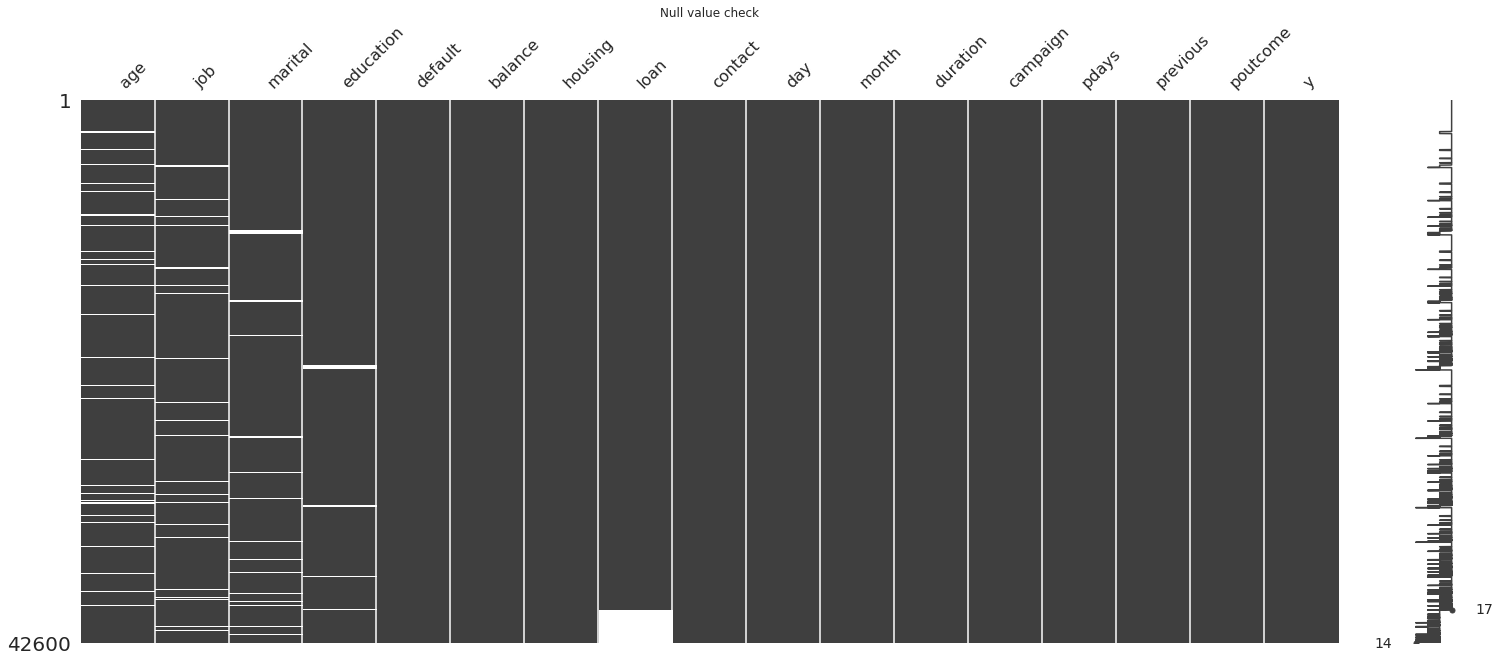

In [17]:

msno.matrix(data);
plt.title("Null value check");

> Null values in age, job, marital, education and loan columns can be observed.

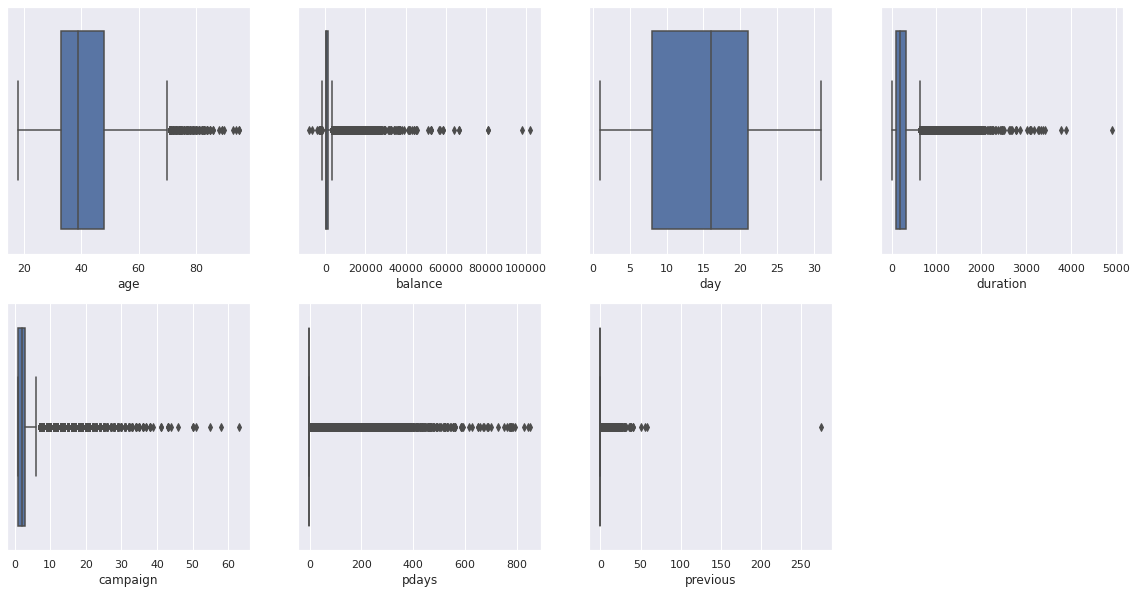

In [18]:
# Boxplot for numerical variables
create_boxplot(data[data.describe().columns])

> Outliers can be seen in pdays, campaign, previous, duration, balance and age.

> I don't remove them because I use tree based models which can handle outliers pretty well.

## Checking for class imbalance 

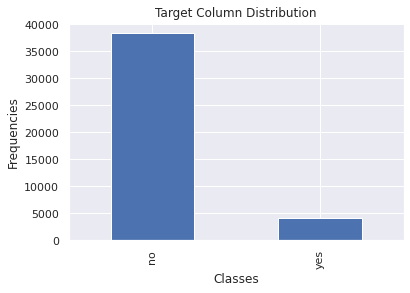

In [19]:

data["y"].value_counts().plot(kind = "bar");
plt.title("Target Column Distribution");
plt.xlabel("Classes");
plt.ylabel("Frequencies");

> A clear class imbalance can be seen here.

> This would have to be handled using sampling methods.

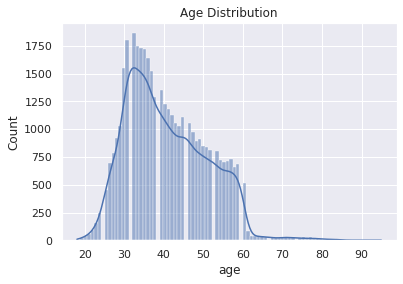

In [20]:
# Lets check the distribution of age column

sns.histplot(data["age"], kde = True);
plt.title("Age Distribution");

> A right skew can be seen here.

> The peak comes around 30.

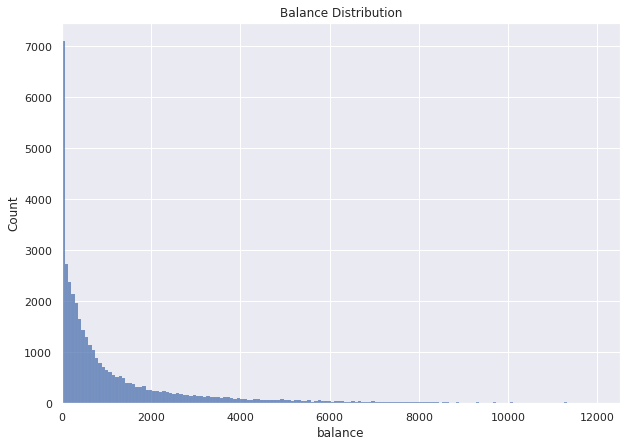

In [71]:
# Lets check the distribution of balance column
plt.figure(figsize = ((10,7)))
sns.histplot(data["balance"], kde = False);
plt.xlim(0,12500)
plt.title("Balance Distribution");

> This is right skewed too.

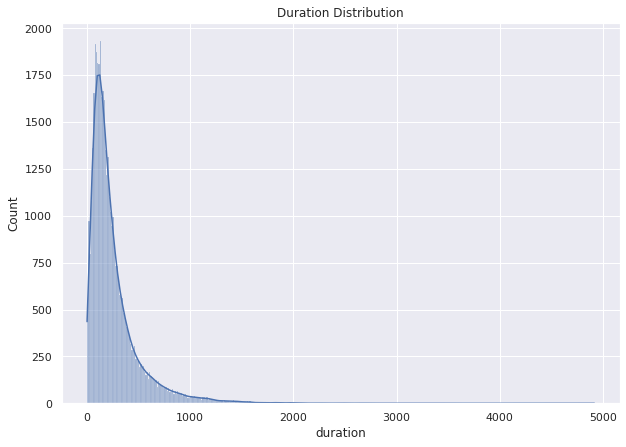

In [22]:
# Lets check the distribution of duration column
plt.figure(figsize = ((10,7)))
sns.histplot(data["duration"], kde = True);
plt.title("Duration Distribution");

> The mode is around 500.

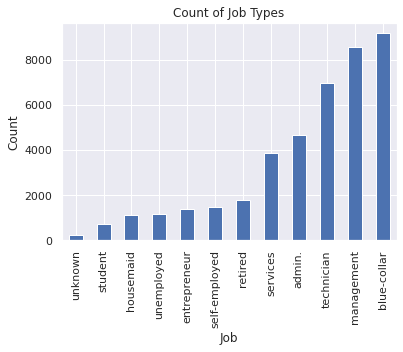

In [23]:
data["job"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Job Types"); 
plt.xlabel("Job");
plt.ylabel("Count");

> Blue collar people are the majority

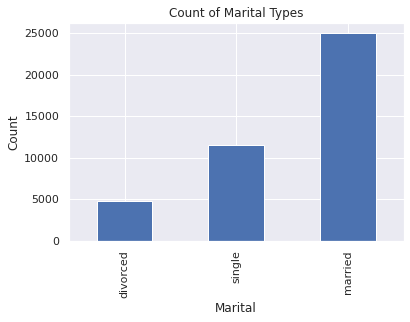

In [24]:
data["marital"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Marital Types"); 
plt.xlabel("Marital");
plt.ylabel("Count");

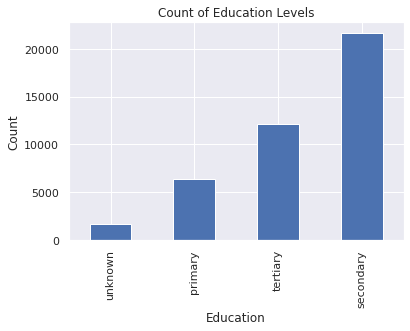

In [25]:

data["education"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Education Levels"); 
plt.xlabel("Education");
plt.ylabel("Count");

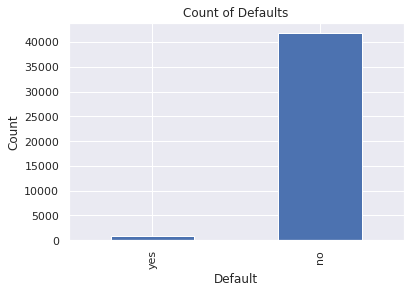

In [26]:
data["default"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Defaults"); 
plt.xlabel("Default");
plt.ylabel("Count");

> Most of the people have not defaulted.

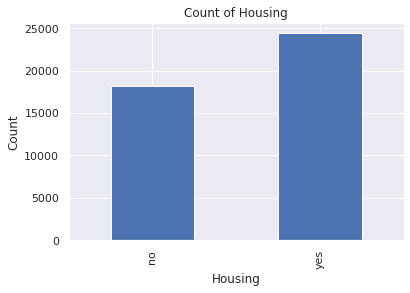

In [27]:
data["housing"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Housing"); 
plt.xlabel("Housing");
plt.ylabel("Count");

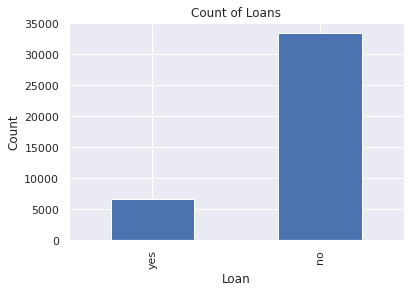

In [28]:
data["loan"].value_counts().sort_values().plot(kind = "bar");
plt.title("Count of Loans"); 
plt.xlabel("Loan");
plt.ylabel("Count");

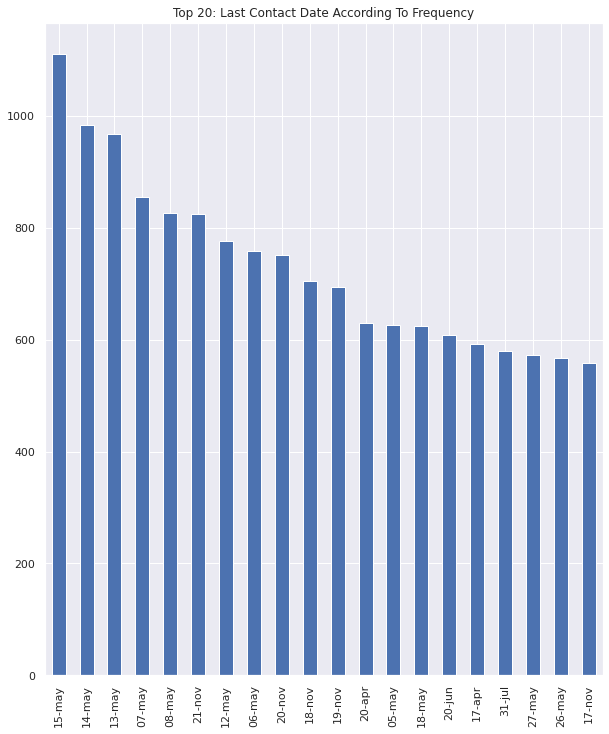

In [29]:
plt.figure(figsize = (10, 12))
data.apply(lambda x: "0" + str(x["day"]) +"-"+ x["month"] if (len(str(x["day"])) < 2) else str(x["day"]) +"-"+ x["month"], axis = 1).value_counts()[:20].plot(kind = "bar")
plt.title("Top 20: Last Contact Date According To Frequency");

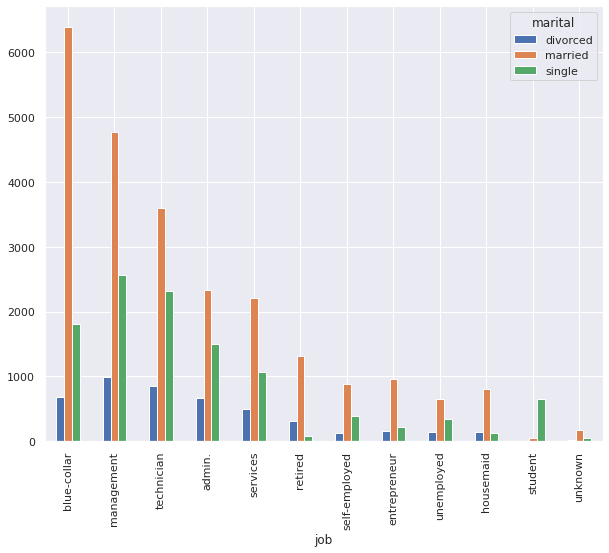

In [30]:
do_a_crosstab(data, "job", "marital")

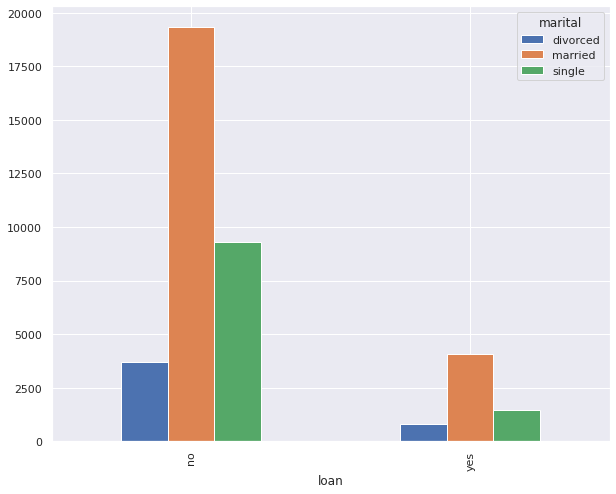

In [31]:
do_a_crosstab(data, "loan", "marital")

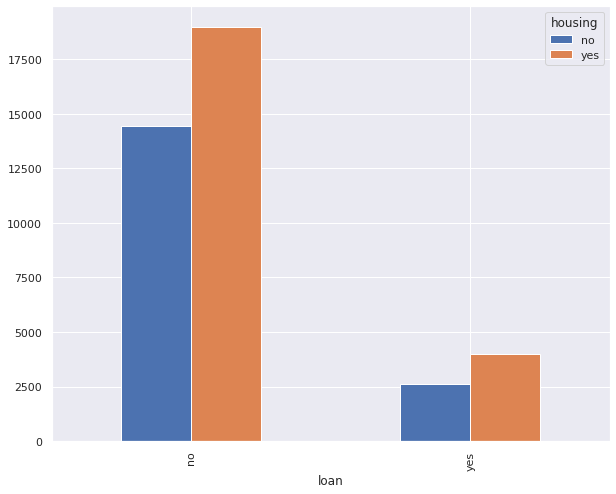

In [32]:
do_a_crosstab(data, "loan", "housing")

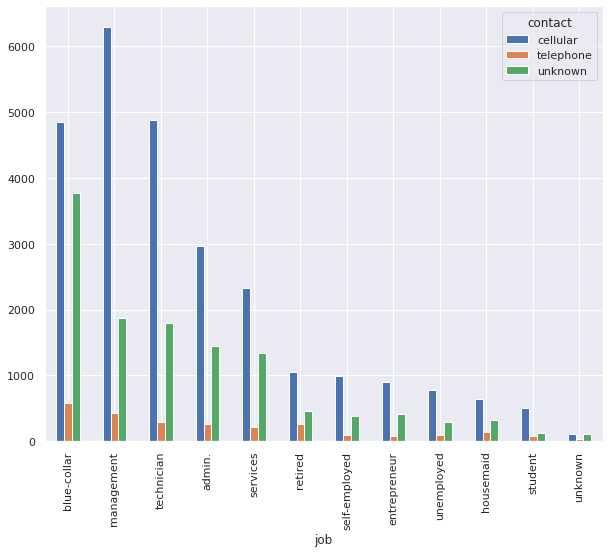

In [33]:
do_a_crosstab(data, "job", "contact")


## Lets fill out the missing values

In [34]:
data.isnull().sum()

age          2656
job          1409
marital      1338
education     660
default         0
balance         0
housing         0
loan         2596
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
y               0
dtype: int64

In [35]:
# There is no point filling them with most frequent, as that can deviate the data from real statistics so better to fill missing value with an unknown value i.e missing here
data["job"] = data['job'].fillna("missing")
data["marital"] = data['marital'].fillna("missing")
data["education"] = data['education'].fillna("missing")

In [36]:
# group by housing, marital status, and education and take mean of that group to fill na values
data["age"] = data.groupby(['housing', 'marital', 'education'])['age'].transform(
    lambda group: group.fillna(np.mean(group))
)

In [37]:
# group by housing and default and take mean of that group to fill na values
data["loan"] = data.groupby(['housing', 'default'])['loan'].transform(
    lambda group: group.fillna(group.mode()[0]))

In [38]:
# Now we don't have any missing values here

data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [39]:
data["y"] = data["y"].map({"yes": 1, "no": 0})

In [40]:
# There is no order so no point of label encoding, better to go ahead with One hot encoding as even if dimensionality increases here its still good enough to process
y = data["y"]
X = pd.get_dummies(data[list(set(data.columns) - set(['y']))])

In [41]:
X.shape, y.shape


((42600, 54), (42600,))

## Checking For Correlated Categorical Columns

In [42]:
categorical_cols = [col for col in data.columns if data[col].dtype == "object"]

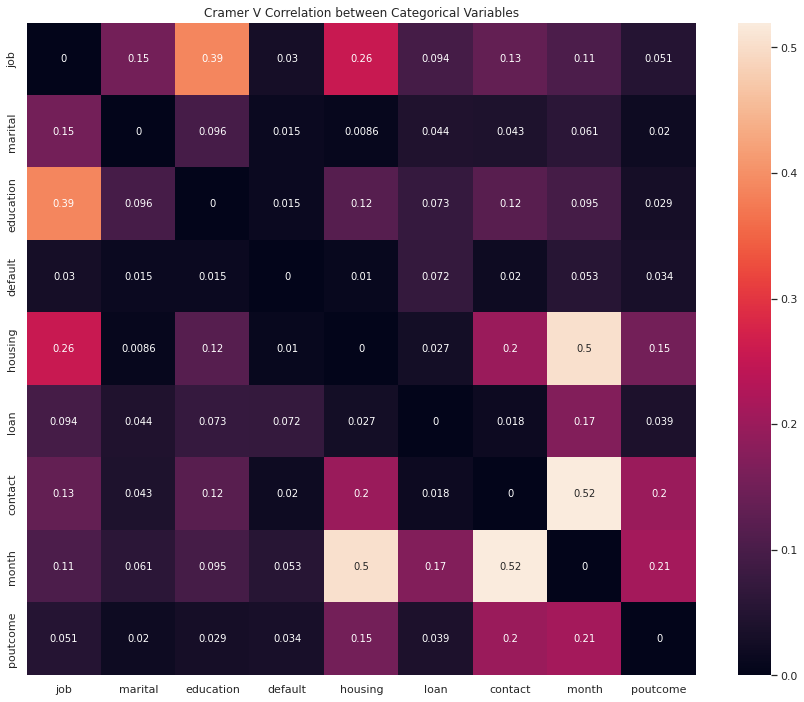

In [43]:
# this gives correlation between categorical variables

correlation_matrix = np.zeros((len(categorical_cols),len(categorical_cols)))

for column1, column2 in itertools.combinations(categorical_cols, 2):
    index1, index2 = categorical_cols.index(column1), categorical_cols.index(column2)
    correlation_matrix[index1, index2] = cramers_corrected_stat_for_heatmap(pd.crosstab(data[column1], data[column2]))
    correlation_matrix[index2, index1] = correlation_matrix[index1, index2]
    
corr = pd.DataFrame(correlation_matrix, index = categorical_cols, columns = categorical_cols)

fig, ax = plt.subplots(figsize=(15, 12))

ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Categorical Variables");


> No strong correlation exists here.

## Correlation For Continuous Variables

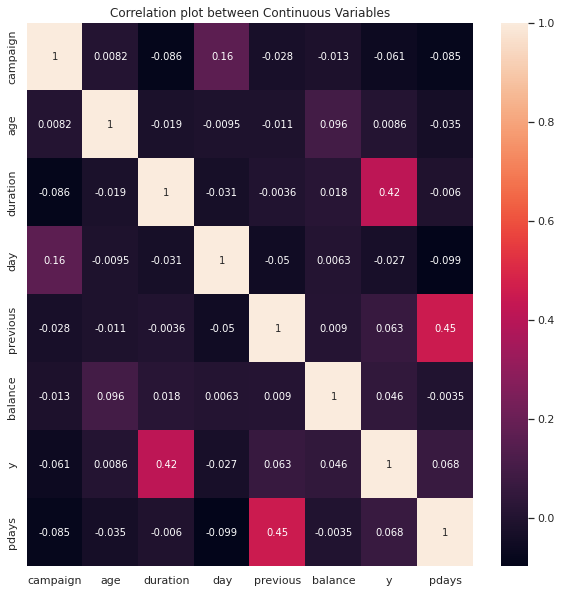

In [44]:
continuous_cols = list(set(data.columns) - set(categorical_cols))


fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(data[continuous_cols].corr(), annot=True, ax=ax); ax.set_title("Correlation plot between Continuous Variables");


> Still no strong correlation.

## Model: Logistic Regression

### Logistic Regression w/ no sampling method

Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5

Mean Accuracy on train set is:  0.9156572769953051
Mean Accuracy on test set is:  0.9151173708920188

Mean F score on train set is: 0.43228382113305897
Mean F score on test set is: 0.4277411346063452

Mean Precision on train set is: 0.642532721538644
Mean Precision on test set is: 0.6372437277236653

Mean Recall on train set is: 0.32571428571428573
Mean Recall on test set is: 0.32261904761904764

Mean Train ROC is: 0.913833251953125
Mean Test ROC is: 0.9124037078373017


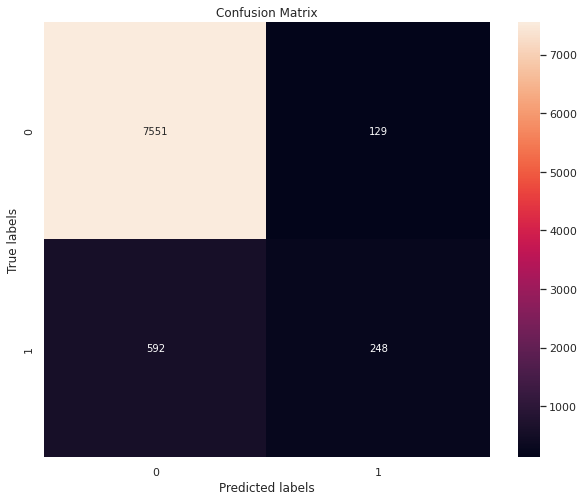

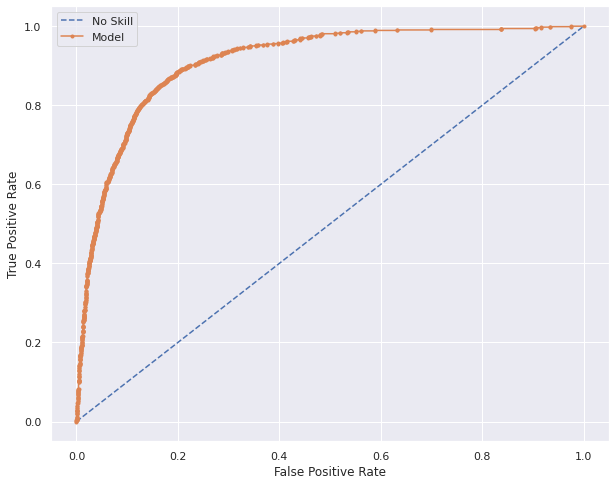

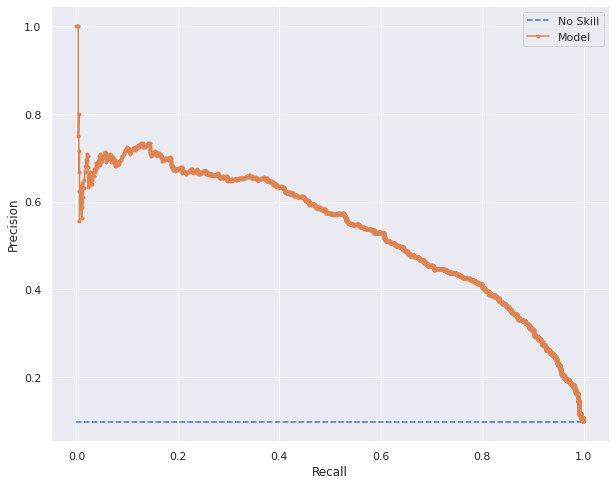

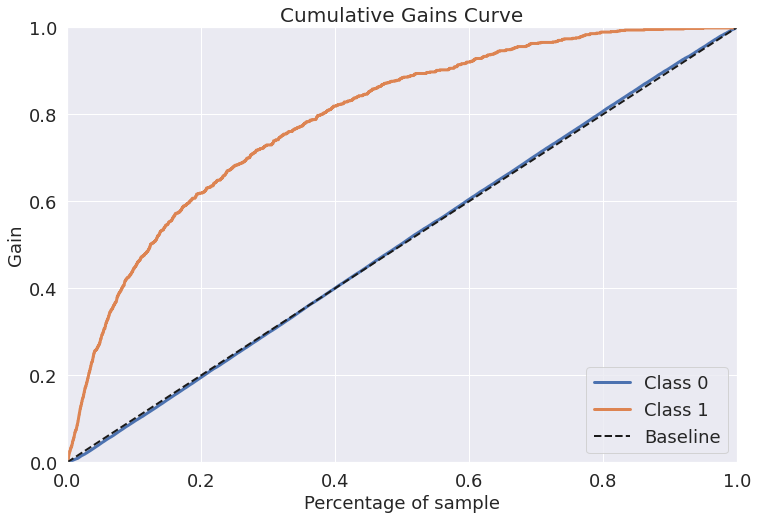

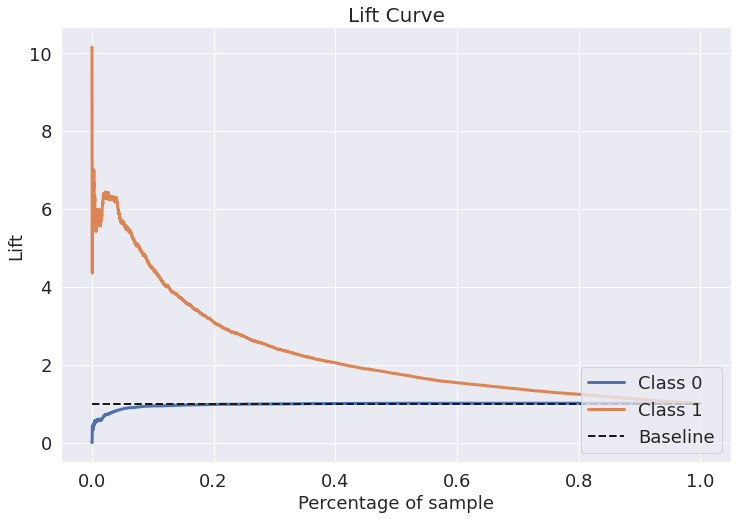

In [53]:
logistic_reg_n = LogisticRegression(solver='liblinear')

logistic_reg_n, lrn_y_test, lrn_y_pred,cols = classifier_no_sampling(logistic_reg_n, X.copy(), y.copy())

In [54]:
# Feature Interpretation
eli5.show_weights(logistic_reg_n, feature_names= list(cols), top = 30)

Weight?,Feature
+1.734,month_mar
+1.539,poutcome_success
+1.168,month_oct
+1.138,duration
+1.038,month_sep
+0.607,month_dec
+0.487,job_retired
+0.432,job_student
+0.415,month_jun
+0.399,contact_cellular


### Logistic Regression w/ SMOTE Oversampling

Fold:  1
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  2
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  3
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  4
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  5
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})


Mean Accuracy on train set is:  0.9381868489583333
Mean Accuracy on test set is:  0.9139201877934273

Mean F score on train set is: 0.9365334482151384
Mea

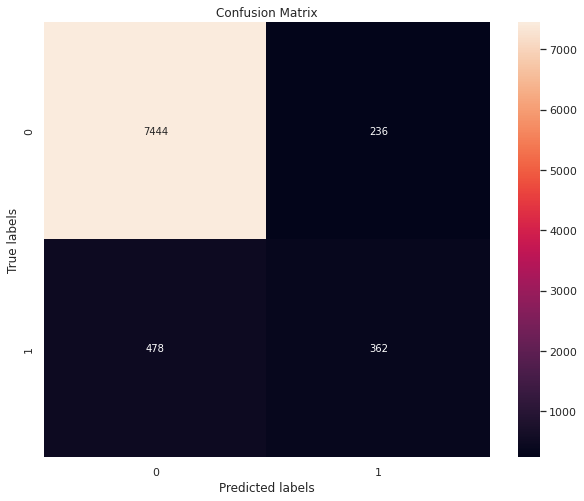

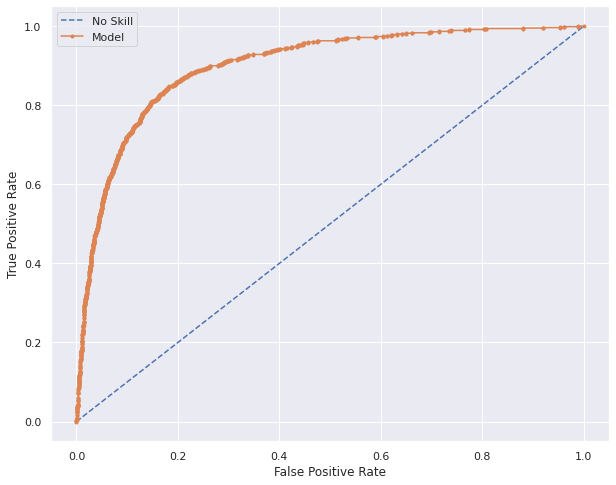

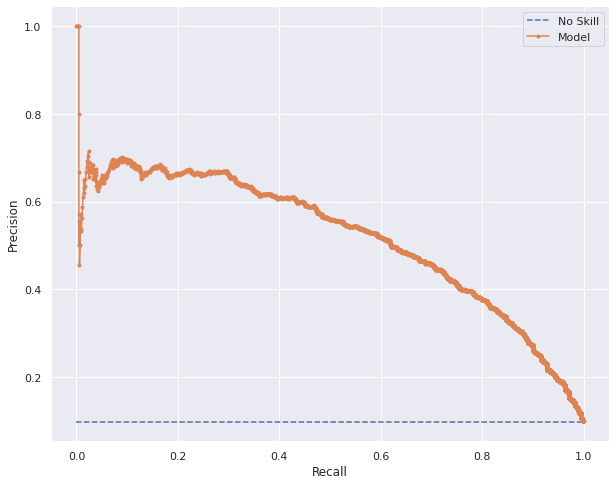

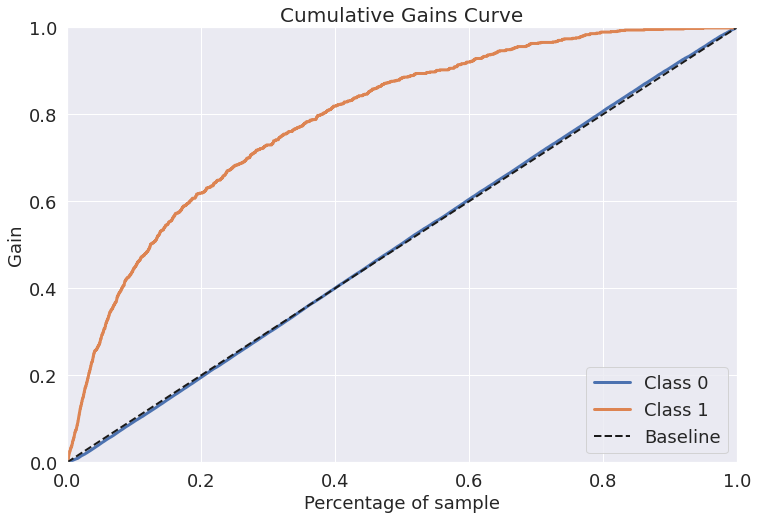

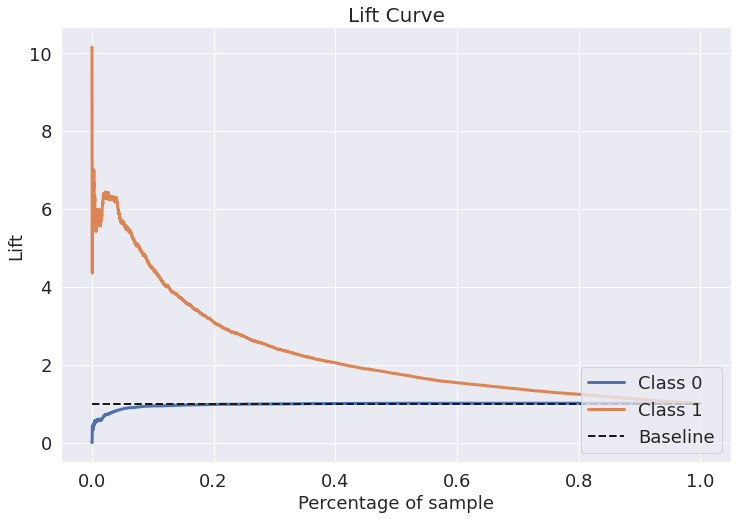

In [55]:
logistic_reg = LogisticRegression(solver='liblinear')

logistic_reg, lr_y_test, lr_y_pred,cols = classifier(logistic_reg, X.copy(), y.copy())

In [56]:
# Feature Interpretation
eli5.show_weights(logistic_reg, feature_names= list(cols), top = 100)

Weight?,Feature
+22.797,<BIAS>
+1.300,duration
+1.033,poutcome_success
+0.078,default_no
+0.036,previous
+0.008,day
-0.001,pdays
-0.006,balance
-0.065,age
-0.359,campaign


## Model: Random Forest w/ SMOTE Oversampling

Fold:  1
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  2
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  3
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  4
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  5
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})


Mean Accuracy on train set is:  1.0
Mean Accuracy on test set is:  0.9102112676056338

Mean F score on train set is: 1.0
Mean F score on test set is: 0.52

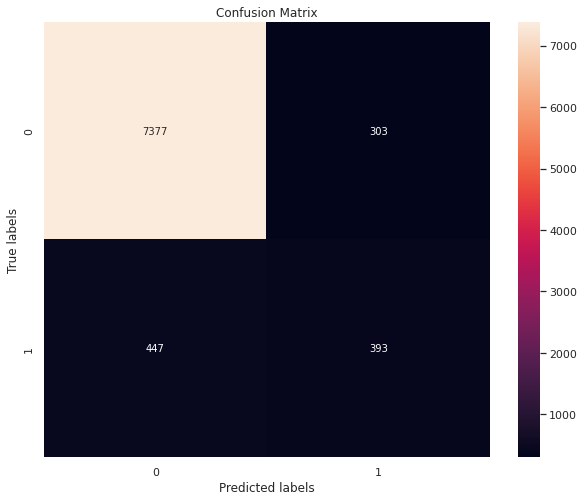

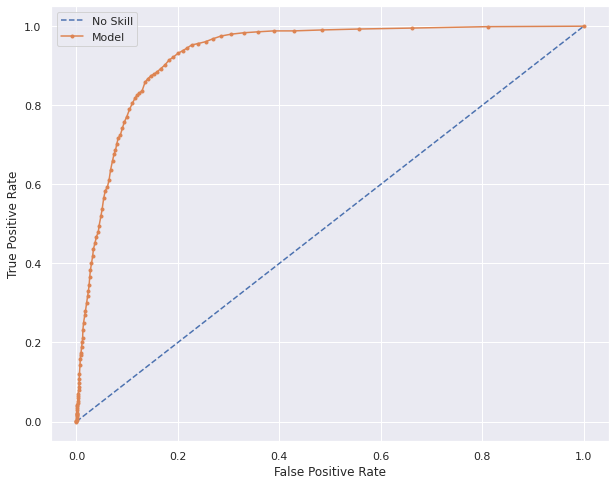

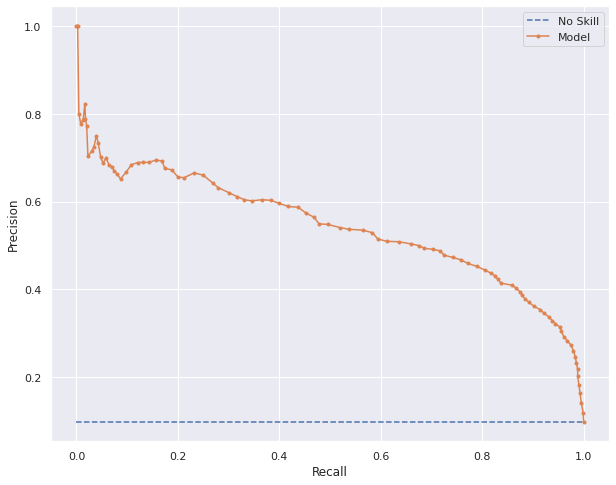

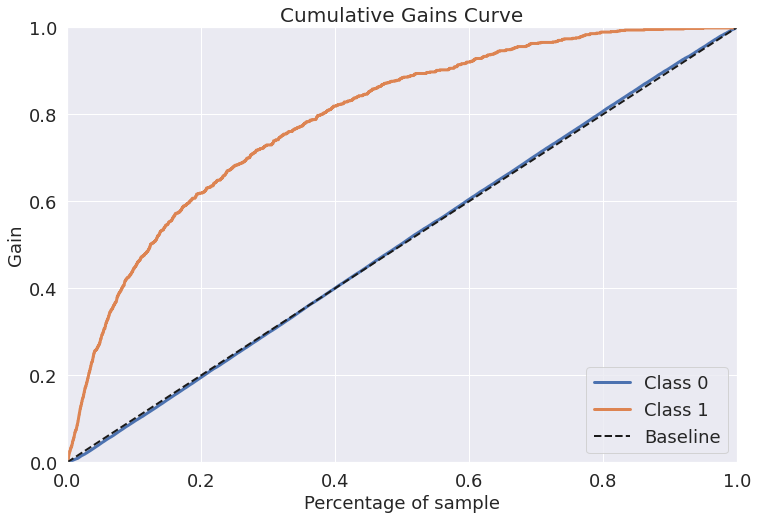

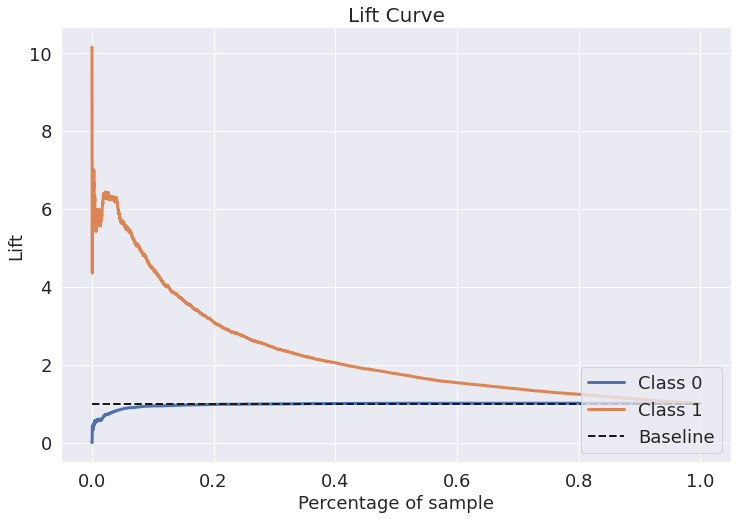

In [57]:
rforest = RandomForestClassifier(random_state=0)
rforest, rf_y_test, rf_y_pred, cols = classifier(rforest, X.copy(), y.copy())

In [58]:
# feature interpretation
eli5.show_weights(rforest, feature_names= list(cols), top = 100)

Weight,Feature
0.3388 ± 0.0926,duration
0.0731 ± 0.0727,campaign
0.0626 ± 0.0320,balance
0.0465 ± 0.0095,day
0.0460 ± 0.0110,age
0.0403 ± 0.0376,housing_yes
0.0359 ± 0.0373,contact_unknown
0.0173 ± 0.0131,month_aug
0.0170 ± 0.0184,job_blue-collar
0.0169 ± 0.0117,month_jul


> For this model, duration followed by campaign have the highest influence on prediction.

### Tuning the hyperparameters of Random Forest

In [59]:
parameters = { 'max_depth': [5,6,7,8, 9],
                 'n_estimators' : [100,500,1000,1500,50],
                 }

X_temp = X.copy()
y_temp = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

# Scaling the data
scaler = StandardScaler()

parameters = { 'max_depth': [5,6,7,8, 9],
                 'n_estimators' : [100,500,1000,1500,50],
                 }

X_train[["age", "balance", "duration", "campaign"]] = scaler.fit_transform(X_train[["age", "balance", "duration", "campaign"]])
X_test[["age", "balance", "duration", "campaign"]] = scaler.fit_transform(X_test[["age", "balance", "duration", "campaign"]])


print('Before applying smote class distribution is: ', Counter(y_train) )
# Applying smote to train data        
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print('After applying smote class distribution is: ', Counter(y_train) )

print()

grid_ = GridSearchCV(estimator=RandomForestClassifier(random_state = 0), param_grid = parameters, cv = 2, n_jobs=4, verbose = 10, scoring='recall')
grid_.fit(X_train, y_train)

print('Before applying smote class distribution is: ', Counter(y_train) )
# Applying smote to train data        
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print('After applying smote class distribution is: ', Counter(y_train) )

print()

grid_ = GridSearchCV(estimator=RandomForestClassifier(random_state = 0), param_grid = parameters, cv = 2, n_jobs=4, verbose = 10, scoring='recall')
grid_.fit(X_train, y_train)


Before applying smote class distribution is:  Counter({0: 30711, 1: 3369})
After applying smote class distribution is:  Counter({0: 30711, 1: 30711})

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Before applying smote class distribution is:  Counter({0: 30711, 1: 30711})
After applying smote class distribution is:  Counter({0: 30711, 1: 30711})

Fitting 2 folds for each of 25 candidates, totalling 50 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=0), n_jobs=4,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'n_estimators': [100, 500, 1000, 1500, 50]},
             scoring='recall', verbose=10)

In [60]:
print(" Results from Grid Search: " )
print("\n The best estimator across ALL searched params for random forest:\n\n", grid_.best_estimator_)
print("\n The best score across ALL searched params for random forest", grid_.best_score_)
print("\n The best parameters across ALL searched params for random forest:\n", grid_.best_params_)
print()
# Getting the best estimator
rf_optimized_model = grid_.best_estimator_


 Results from Grid Search: 

 The best estimator across ALL searched params for random forest:

 RandomForestClassifier(max_depth=9, n_estimators=1500, random_state=0)

 The best score across ALL searched params for random forest 0.9389787107569412

 The best parameters across ALL searched params for random forest:
 {'max_depth': 9, 'n_estimators': 1500}



Fold:  1
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  2
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  3
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  4
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  5
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})


Mean Accuracy on train set is:  0.9177766927083333
Mean Accuracy on test set is:  0.864413145539906

Mean F score on train set is: 0.9205022913991494
Mean

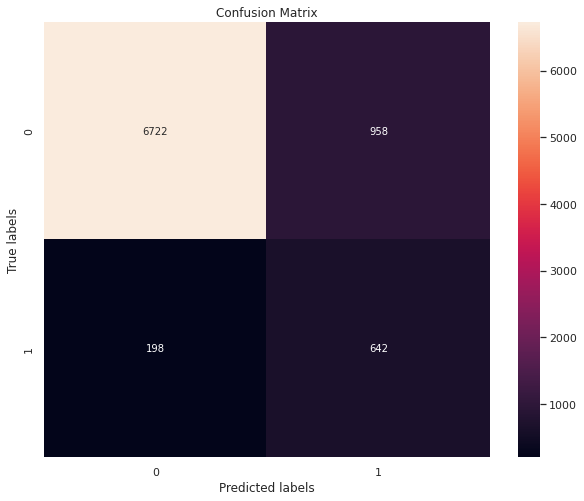

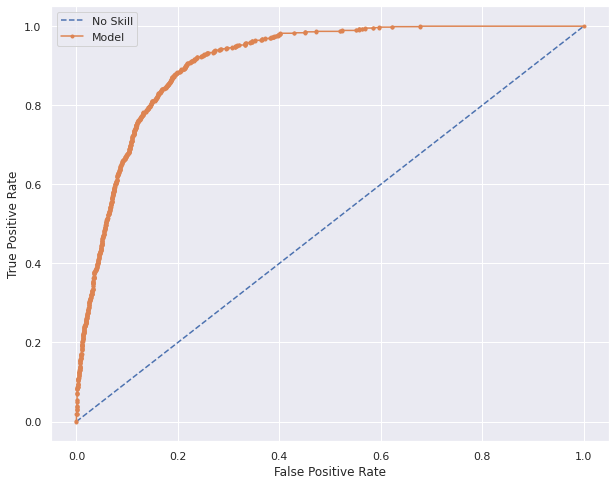

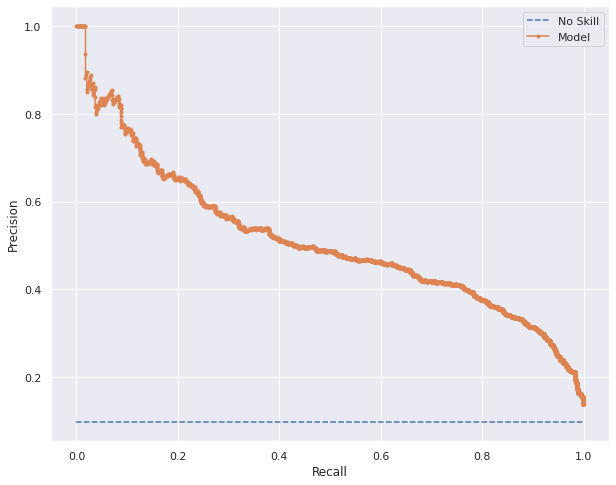

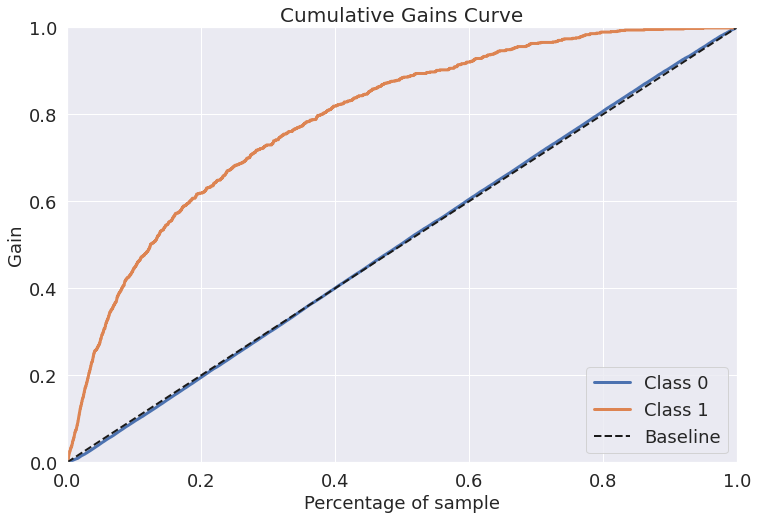

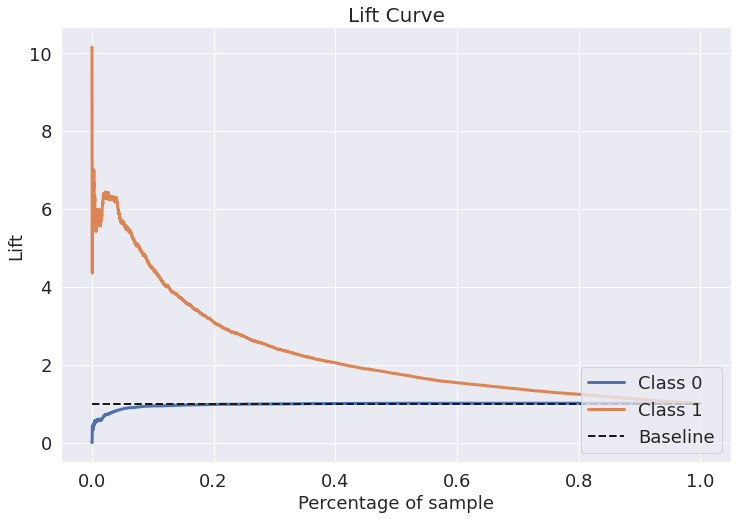

In [61]:
rf_optimized_model, rf_opt_y_test, rf_opt_y_pred, cols = classifier(rf_optimized_model, X.copy(), y.copy())

In [69]:
eli5.show_weights(rf_optimized_model, feature_names= list(X.columns), top = 100)

Weight,Feature
0.4242 ± 0.2406,duration
0.0717 ± 0.1507,campaign
0.0642 ± 0.0881,housing_yes
0.0631 ± 0.0973,contact_unknown
0.0443 ± 0.0693,balance
0.0269 ± 0.0504,loan_yes
0.0220 ± 0.0490,job_blue-collar
0.0205 ± 0.0430,marital_married
0.0172 ± 0.0428,housing_no
0.0155 ± 0.0423,month_may


## Model: LGBM

Fold:  1
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  2
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  3
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  4
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  5
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})


Mean Accuracy on train set is:  0.9604654947916668
Mean Accuracy on test set is:  0.9180281690140845

Mean F score on train set is: 0.9603822736290475
Mea

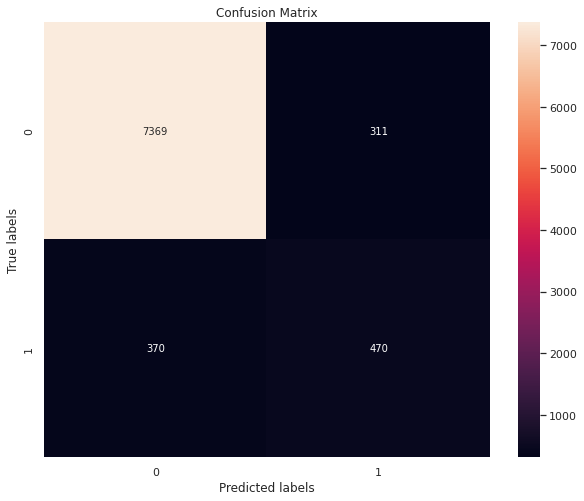

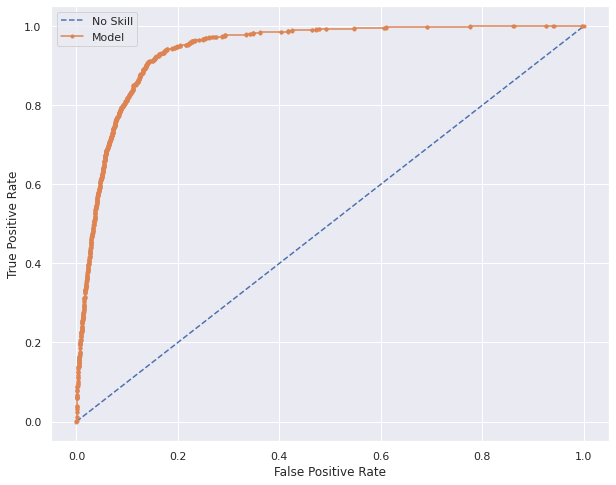

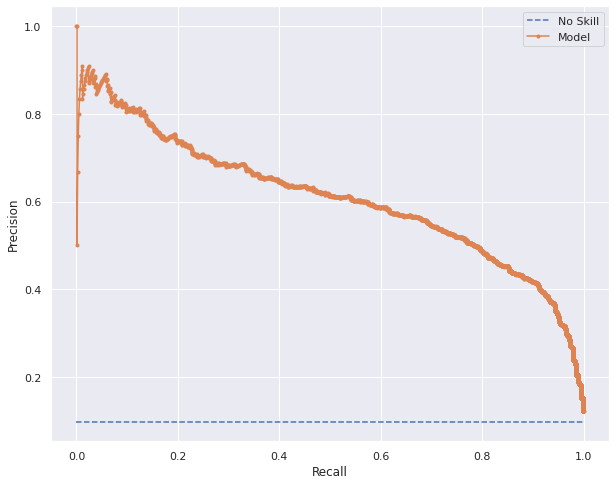

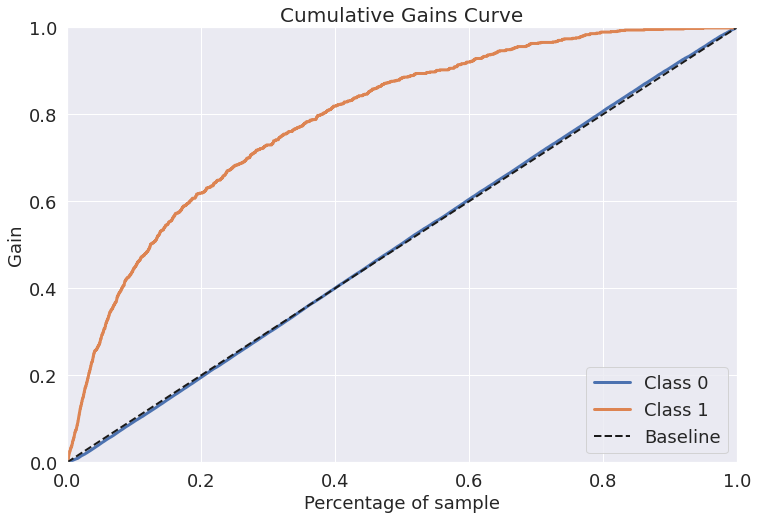

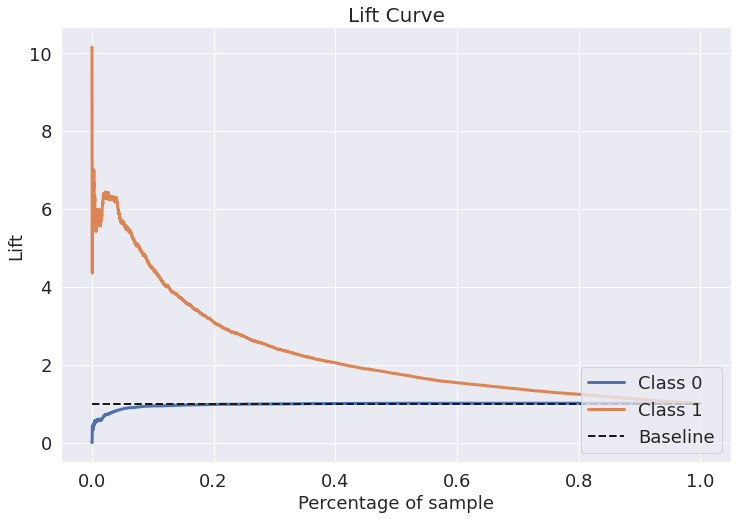

In [62]:

lgb = LGBMClassifier(n_jobs=-1)
lgb, lgb_y_test, lgb_opt_y_pred,cols = classifier(lgb, X.copy(), y.copy())

In [63]:
# feature interpretation
eli5.show_weights(lgb, feature_names= list(X.columns), top = 100)

Weight,Feature
0.3600,duration
0.0875,campaign
0.0796,housing_yes
0.0623,contact_unknown
0.0338,month_jul
0.0332,month_aug
0.0260,day
0.0204,month_nov
0.0180,balance
0.0171,housing_no


## Tuning the hyperparameters of LGBM


In [64]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20)

# Scaling the data
scaler = StandardScaler()

X_train[["age", "balance", "duration", "campaign"]] = scaler.fit_transform(X_train[["age", "balance", "duration", "campaign"]])
X_test[["age", "balance", "duration", "campaign"]] = scaler.fit_transform(X_test[["age", "balance", "duration", "campaign"]])


print('Before applying smote class distribution is: ', Counter(y_train) )
# Applying smote to train data        
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print('After applying smote class distribution is: ', Counter(y_train) )

print()


# Defining parameter grid for LGBM

# A parameter grid for LGBM
parameters = { 'max_depth': [5,6,7,8, 9],
                 'learning_rate' : [0.01,0.02,0.03],
                  'num_iterations'    : [100, 200, 500, 1000]
                 }

grid_ = GridSearchCV(estimator=LGBMClassifier(n_jobs=-1), param_grid = parameters, cv = 2, n_jobs=4, verbose = 10, scoring='recall')
grid_.fit(X_train, y_train)

Before applying smote class distribution is:  Counter({0: 30697, 1: 3383})
After applying smote class distribution is:  Counter({0: 30697, 1: 30697})

Fitting 2 folds for each of 60 candidates, totalling 120 fits


GridSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'max_depth': [5, 6, 7, 8, 9],
                         'num_iterations': [100, 200, 500, 1000]},
             scoring='recall', verbose=10)

In [65]:
print(" Results from Grid Search: " )
print("\n The best estimator across ALL searched params for LGBM:\n\n", grid_.best_estimator_)
print("\n The best score across ALL searched params for LGBM", grid_.best_score_)
print("\n The best parameters across ALL searched params for LGBM:\n", grid_.best_params_)
print()
# Getting the best estimator
lgbm_optimized_model = grid_.best_estimator_


 Results from Grid Search: 

 The best estimator across ALL searched params for LGBM:

 LGBMClassifier(learning_rate=0.02, max_depth=5, num_iterations=200)

 The best score across ALL searched params for LGBM 0.9401232513680952

 The best parameters across ALL searched params for LGBM:
 {'learning_rate': 0.02, 'max_depth': 5, 'num_iterations': 200}



Fold:  1
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  2
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  3
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  4
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})

Fold:  5
Before applying any strategy, class distribution is:  Counter({0: 30720, 1: 3360})
After applying SMOTE, class distribution is:  Counter({0: 30720, 1: 30720})


Mean Accuracy on train set is:  0.9276985677083335
Mean Accuracy on test set is:  0.8832863849765259

Mean F score on train set is: 0.9295833409511713
Mea

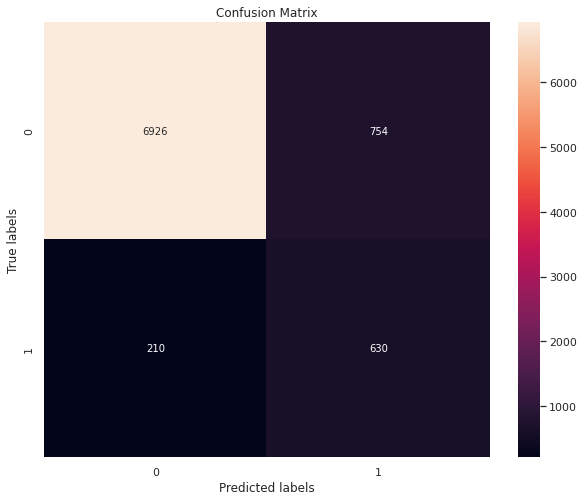

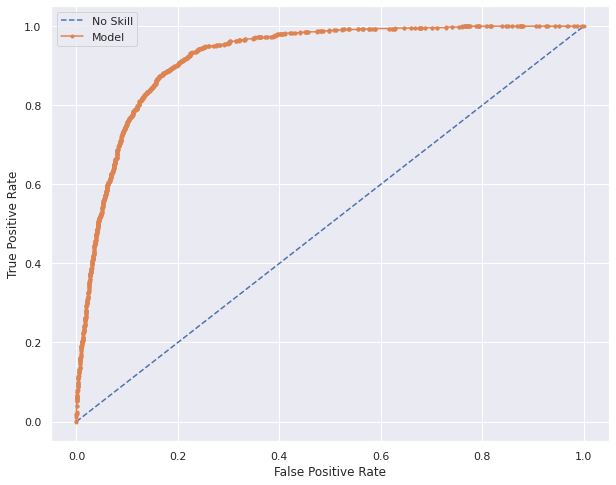

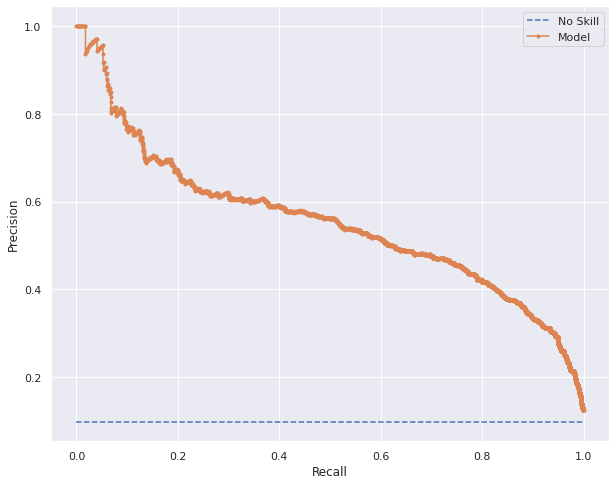

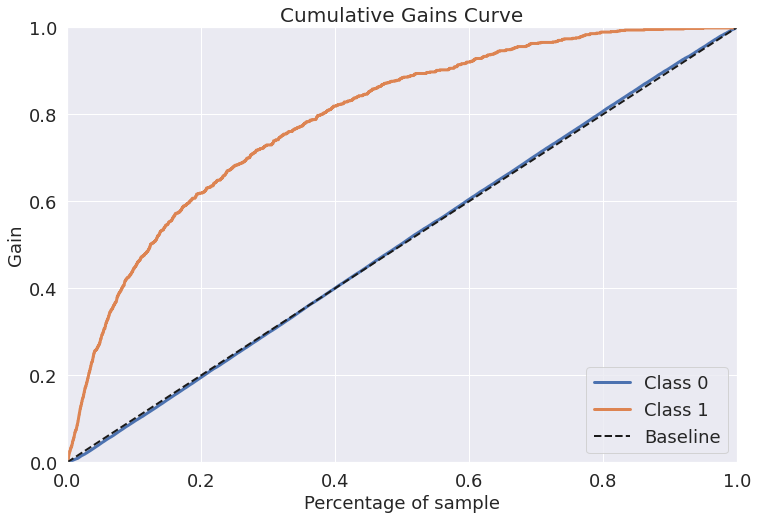

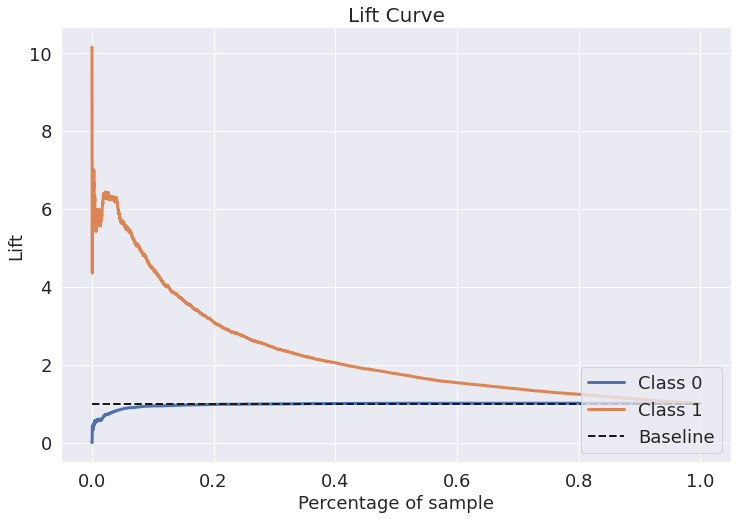

In [66]:

lgbm_optimized_model, lgbm_optimized_model_y_test, lgbm_optimized_model_opt_y_pred, cols = classifier(lgbm_optimized_model, X.copy(), y.copy())


In [68]:
eli5.show_weights(lgbm_optimized_model, feature_names= list(X.columns), top = 100)

Weight,Feature
0.4374,duration
0.0946,campaign
0.0926,housing_yes
0.0647,contact_unknown
0.0321,month_aug
0.0311,month_jul
0.0199,housing_no
0.0184,balance
0.0147,pdays
0.0145,month_nov


## Conclusion

> LGBM seems to be performing the best here. Since this is a classification task, ROC and F scores are better metrics than accuracy.
> ROC looks pretty amazing for both train and test sets. F score suffers even though we have created synthetic data because of the class imbalance.